# Setting

## colab connection

In [1]:
from google.colab import drive
drive.mount('/content/data')

Drive already mounted at /content/data; to attempt to forcibly remount, call drive.mount("/content/data", force_remount=True).


## library install & import

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from os.path import join as opj
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 10, 10
%matplotlib inline

In [4]:
import torch
from torch import nn
import torchvision 
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets, models

In [5]:
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

In [6]:
from pathlib import Path

In [7]:
from PIL import Image
import cv2 

In [8]:
# cpu, gpu 설정
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## Global variables

In [9]:
import easydict
args = easydict.EasyDict()

args.default_path = '/content/data/MyDrive/AI Analysis/프로젝트/iceberg/'
args.train_json = args.default_path + 'data/train.json'
args.test_json = args.default_path + 'data/test.json'
args.default_submission_csv = args.default_path+'sample_submission.csv'

args.random_state = 42

In [10]:
data_path = Path(args.default_path)
image_path = data_path / "data"

# Load data
- id: 이미지의 id
- band_1: 수직으로 촬영한 사진(HH)
- band_2: 특정 각도에서 촬영한 사진(HV)
- inc_angle: 이미지 촬영 시 지면과의 각
- is_iceberg: 1 = 빙하, 0 = 배

In [11]:
train = pd.read_json(args.train_json)
test = pd.read_json(args.test_json)

In [12]:
test.isnull().sum()

id           0
band_1       0
band_2       0
inc_angle    0
dtype: int64

In [13]:
train.head()

,id,band_1,band_2,inc_angle,is_iceberg
0,dfd5f913,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",43.9239,0
1,e25388fd,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",38.1562,0
2,58b2aaa0,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",45.2859,1
3,4cfc3a18,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",43.8306,0
4,271f93f4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",35.6256,0


# Data processing

## train data 

In [14]:
len(train.iloc[0,1]) 

5625

In [15]:
X_band_1 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train['band_1']])
X_band_2 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train['band_2']])
X_band_3 = ((X_band_1 + X_band_2)/2)

In [21]:
for i in range(len(X_band_1)):
    X_band_1[i] -= X_band_1[i].mean()

    X_band_1[i][X_band_1[i] < X_band_1[i].std() * 1.5] = 0

    X_band_1[i] = X_band_1[i] / X_band_1[i].max()

In [22]:
for i in range(len(X_band_2)):
    X_band_2[i] -= X_band_2[i].mean()

    X_band_2[i][X_band_2[i] < X_band_2[i].std() * 1.5] = 0

    X_band_2[i] = X_band_2[i] / X_band_2[i].max()
    
for i in range(len(X_band_3)):
    X_band_3[i] -= X_band_3[i].mean()

    X_band_3[i][X_band_3[i] < X_band_3[i].std() * 1.5] = 0

    X_band_3[i] = X_band_3[i] / X_band_3[i].max()

In [23]:
X_img = np.concatenate([X_band_1[:,:,:,np.newaxis], X_band_2[:,:,:,np.newaxis], X_band_3[:,:,:,np.newaxis]], axis=-1)

In [24]:
X_img.shape

(1604, 75, 75, 3)

In [25]:
y_label = train['is_iceberg'].values

## test data

In [26]:
x_band_1 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test['band_1']])
x_band_2 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test['band_2']])
x_band_3 = ((x_band_1 + x_band_2)/2)

In [29]:
for i in range(len(x_band_1)):
    x_band_1[i] -= x_band_1[i].mean()
    x_band_1[i][x_band_1[i] < x_band_1[i].std() * 1.5] = 0
    x_band_1[i] = x_band_1[i] / x_band_1[i].max()
    x_band_2[i] -= x_band_2[i].mean()
    x_band_2[i][x_band_2[i] < x_band_2[i].std() * 1.5] = 0
    x_band_2[i] = x_band_2[i] / x_band_2[i].max()
    x_band_3[i] -= x_band_3[i].mean()
    x_band_3[i][x_band_3[i] < x_band_3[i].std() * 1.5] = 0
    x_band_3[i] = x_band_3[i] / x_band_3[i].max()

In [33]:
x_test = np.concatenate([x_band_1[:,:,:,np.newaxis], x_band_2[:,:,:,np.newaxis], x_band_3[:,:,:,np.newaxis]], axis=-1)

In [34]:
x_test.shape

(8424, 75, 75, 3)

## data image sample

In [35]:
train.loc[14, 'is_iceberg']

0

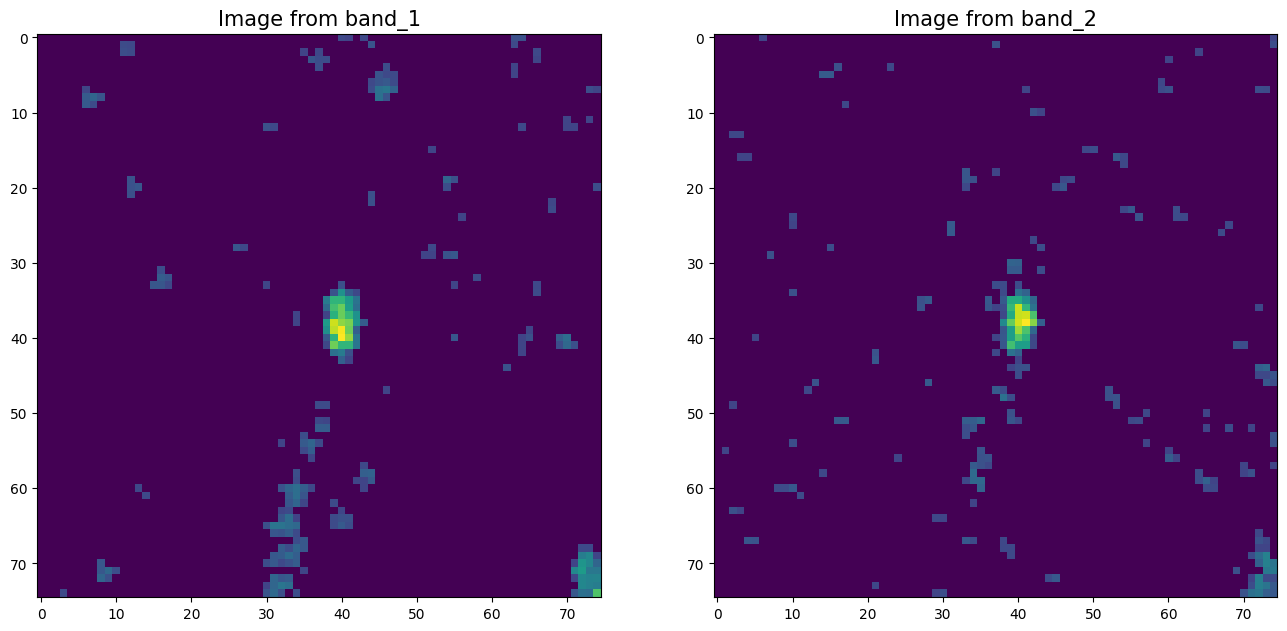

In [36]:
fig, ax = plt.subplots(1,2,figsize=(16,10))
ax[0].imshow(X_band_1[14,:,:])
ax[0].set_title('Image from band_1', fontsize=15)
ax[1].imshow(X_band_2[14,:,:])
ax[1].set_title('Image from band_2', fontsize=15)
plt.show()

# Dataset

In [37]:
class IcebergCustom(Dataset):
    def __init__(self, data, labels=None, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index: int):
        img = self.data[index]
        labels = self.labels

        if self.transform:
            img = self.transform(img)

        if labels is None:
            return img

        labels = self.labels[index]
        labels = torch.tensor(labels, dtype=torch.float32)

        return img, labels

In [38]:
cnn_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((64,64))
])

## train, validation set split

In [39]:
X_train,X_val,y_train,y_val=train_test_split(X_img,y_label,
                                            test_size=0.3,
                                            stratify=y_label, 
                                            random_state=args.random_state)

In [40]:
X_train.shape 

(1122, 75, 75, 3)

In [41]:
train_data_custom = IcebergCustom(X_train, y_train, transform=cnn_transforms)

In [42]:
val_data_custom = IcebergCustom(X_val, y_val, transform=cnn_transforms)

In [43]:
im= torch.permute(train_data_custom[2][0], (1,2,0))

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning:

The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).



Image shape: torch.Size([64, 64, 3])


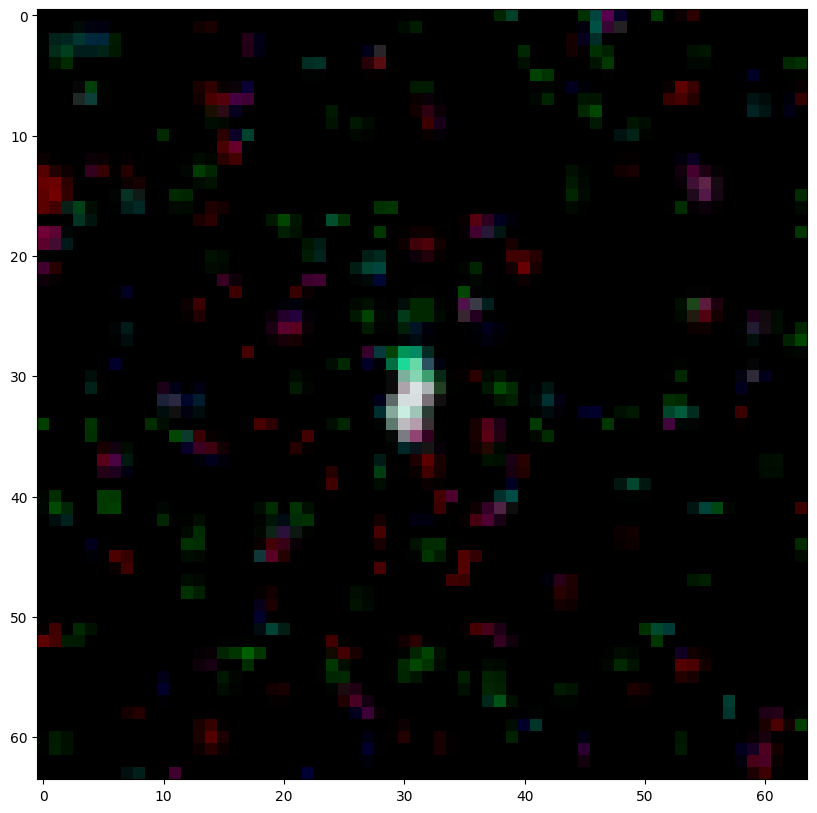

In [44]:
print(f"Image shape: {im.shape}") 
plt.imshow(im) 

# Dataloader

In [48]:
BATCH_SIZE = 32
torch.manual_seed(42)

train_dataloader = DataLoader(train_data_custom,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

val_dataloader = DataLoader(val_data_custom,
                            batch_size=BATCH_SIZE,
                            shuffle=False)

print(f"Dataloaders: {train_dataloader, val_dataloader}") 
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of validation dataloader: {len(val_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7f20779c2dd0>, <torch.utils.data.dataloader.DataLoader object at 0x7f20779a7280>)
Length of train dataloader: 36 batches of 32
Length of validation dataloader: 16 batches of 32


# Model 1: CNN 모델

In [49]:
class CNNModel(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                    out_channels=hidden_units, 
                    kernel_size=3, 
                    stride=1, 
                    padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,
                        stride=3) 
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(5)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*4*4, 
                        out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

In [50]:
torch.manual_seed(42)

cnn_model = CNNModel(input_shape=3, 
    hidden_units=10, 
    output_shape=1).to(device)

cnn_model

CNNModel(
  (block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=160, out_features=1, bias=True)
  )
)

In [51]:
# accuracy fn 만들기
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() 
    acc = (correct / len(y_pred)) * 100
    return acc

In [52]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=cnn_model.parameters(), lr=0.001)

In [53]:
def train_step(model: torch.nn.Module,
                data_loader: torch.utils.data.DataLoader,
                loss_fn: torch.nn.Module,
                optimizer: torch.optim.Optimizer,
                accuracy_fn,
                device: torch.device = device):
    
    model.train()
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X = X.to(device)
        y = y.to(device)
        y = y.unsqueeze(1)
        # 1. Forward 학습
        y_pred = model(X)

        # 2. 손실 계산
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        y_pred = y_pred.squeeze()
        y = y.squeeze() #(64,1)tensor -> (64)tensor
        y_pred = torch.where(y_pred >=0.5, 1, 0)
        train_acc += accuracy_fn(y_true=y,
                                y_pred=y_pred) 

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)

    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
    return train_loss, train_acc

In [54]:
def test_step(data_loader: torch.utils.data.DataLoader,
                model: torch.nn.Module,
                loss_fn: torch.nn.Module,
                accuracy_fn,
                device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.eval() 

    with torch.inference_mode(): 
        for X, y in data_loader:

            X = X.to(device)
            y = y.to(device)
            y = y.unsqueeze(1)
            
            test_pred = model(X)
            test_loss += loss_fn(test_pred, y)

            test_pred = test_pred.squeeze()
            test_pred = torch.where(test_pred >= 0.5, 1, 0)
            test_acc += accuracy_fn(y_true=y.squeeze(),
                                    y_pred=test_pred)
        
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")
        return test_loss, test_acc

In [55]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# 시간 재기
from tqdm.auto import tqdm
from timeit import default_timer as timer
start_time = timer()


cnn_results = {"train_loss" : [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": [],
               "best_weight": ''}

min_test_losses = 1

epochs = 30
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch} \n---------")
    train_loss, train_acc = train_step(data_loader=train_dataloader,
               model=cnn_model, # CNN Model
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device=device
               )
    test_loss, test_acc = test_step(data_loader=val_dataloader,
              model=cnn_model,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn,
              device=device
              )
    if test_loss <= min_test_losses:
        cnn_results["best_weight"] = cnn_model.state_dict()

    print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
      )
    cnn_results["train_loss"].append(train_loss)
    cnn_results["train_acc"].append(train_acc)
    cnn_results["test_loss"].append(test_loss)
    cnn_results["test_acc"].append(test_acc)

    min_test_losses = min(cnn_results['test_loss'])

end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 0 
---------


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning:

The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).



Train loss: 0.69284 | Train accuracy: 54.25%
Test loss: 0.69377 | Test accuracy: 50.00%

Epoch: 1 | train_loss: 0.6928 | train_acc: 54.2535 | test_loss: 0.6938 | test_acc: 50.0000
Epoch: 1 
---------
Train loss: 0.69235 | Train accuracy: 51.65%
Test loss: 0.69165 | Test accuracy: 50.00%

Epoch: 2 | train_loss: 0.6923 | train_acc: 51.6493 | test_loss: 0.6917 | test_acc: 50.0000
Epoch: 2 
---------
Train loss: 0.68557 | Train accuracy: 51.65%
Test loss: 0.68160 | Test accuracy: 50.00%

Epoch: 3 | train_loss: 0.6856 | train_acc: 51.6493 | test_loss: 0.6816 | test_acc: 50.0000
Epoch: 3 
---------
Train loss: 0.65613 | Train accuracy: 54.17%
Test loss: 0.66269 | Test accuracy: 50.00%

Epoch: 4 | train_loss: 0.6561 | train_acc: 54.1667 | test_loss: 0.6627 | test_acc: 50.0000
Epoch: 4 
---------
Train loss: 0.60308 | Train accuracy: 60.07%
Test loss: 0.60592 | Test accuracy: 62.70%

Epoch: 5 | train_loss: 0.6031 | train_acc: 60.0694 | test_loss: 0.6059 | test_acc: 62.6953
Epoch: 5 
---------


In [56]:
def plot_loss_curves(results):

    loss = results['train_loss']
    test_loss = results['test_loss']

    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    epochs = range(len(results['train_loss']))

    plt.figure(figsize=(15, 7))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

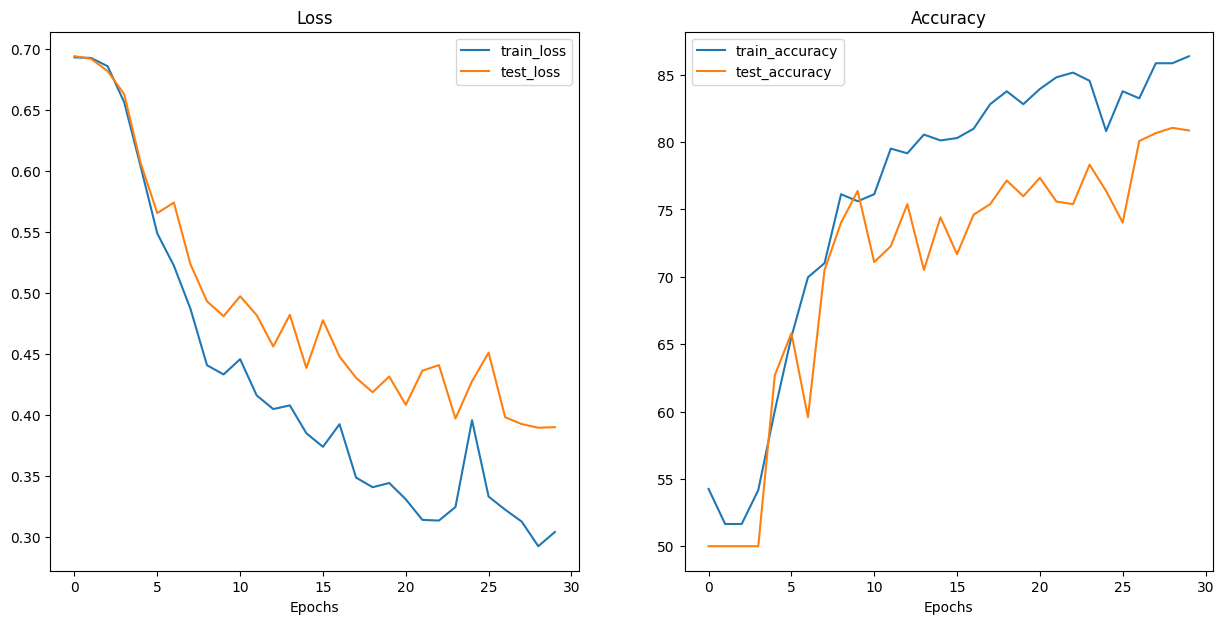

In [57]:
plot_loss_curves(cnn_results)

# Model 2: 전이학습 모델(EfficientNet)

In [58]:
import torch
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

In [59]:

import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:

  model.train()

  train_loss, train_acc = 0, 0

  for batch, (X, y) in enumerate(dataloader):
      X = X.to(device)
      y = y.unsqueeze(1)
      y = y.to(device)

      y_pred = model(X)

      loss = loss_fn(y_pred, y)
      train_loss += loss.item() 

      optimizer.zero_grad()

      loss.backward()

      optimizer.step()
      
      y_pred = y_pred.squeeze()
      y = y.squeeze()
      y_pred_class = torch.where(y_pred >= 0.5, 1, 0)
      train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:

  model.eval() 

  test_loss, test_acc = 0, 0

  with torch.inference_mode():

      for batch, (X, y) in enumerate(dataloader):
          X = X.to(device)
          y = y.unsqueeze(1)
          y = y.to(device)

          test_pred_logits = model(X)

          loss = loss_fn(test_pred_logits, y)
          test_loss += loss.item()

          test_pred_logits = test_pred_logits.squeeze()
          y = y.squeeze()
          test_pred_labels = torch.where(test_pred_logits >= 0.5, 1, 0)
          test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:

  results = {"train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": [],
      "best_weight": ''
  }

  min_test_losses = 1

  for epoch in tqdm(range(epochs)):
      train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
      test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)
      
      if test_loss <= min_test_losses:
          results['best_weight'] = model.state_dict()

      print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
      )

      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)

      min_test_losses = min(results['test_loss'])

  return results


In [60]:
# 전이학습에 필요한 버전 다운로드 

try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

In [61]:
# transform pipeline 매뉴얼
manual_transforms = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Resize((64, 64)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225]),
])

In [62]:
train_data_transfer = IcebergCustom(X_train, y_train, transform=manual_transforms)
val_data_transfer = IcebergCustom(X_val, y_val, transform=manual_transforms)

In [63]:
BATCH_SIZE = 32
torch.manual_seed(42)

train_dataloader = DataLoader(train_data_transfer,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

val_dataloader = DataLoader(val_data_transfer,
                            batch_size=BATCH_SIZE,
                            shuffle=False)

In [64]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT 
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [65]:
efficient_model = torchvision.models.efficientnet_b0(weights=weights).to(device)
efficient_model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [66]:
# 학습하지 않을 레이어 잠그기

for param in efficient_model.features.parameters():
    param.requires_grad = False

In [67]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

output_shape = 1

efficient_model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=efficient_model.classifier[1].in_features, 
                    out_features=output_shape, 
                    bias=True)).to(device)

In [68]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(efficient_model.parameters(), lr=0.001)

In [69]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer 
start_time = timer()

efficient_results = train(model=efficient_model,
                    train_dataloader=train_dataloader,
                    test_dataloader=val_dataloader,
                    optimizer=optimizer,
                    loss_fn=loss_fn,
                    epochs=20,
                    device=device)

end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6717 | train_acc: 0.5634 | test_loss: 0.6421 | test_acc: 0.5566
Epoch: 2 | train_loss: 0.6094 | train_acc: 0.6128 | test_loss: 0.6303 | test_acc: 0.5918
Epoch: 3 | train_loss: 0.5646 | train_acc: 0.6701 | test_loss: 0.6195 | test_acc: 0.6074
Epoch: 4 | train_loss: 0.5582 | train_acc: 0.6884 | test_loss: 0.6234 | test_acc: 0.6035
Epoch: 5 | train_loss: 0.5557 | train_acc: 0.6979 | test_loss: 0.6012 | test_acc: 0.6016
Epoch: 6 | train_loss: 0.5354 | train_acc: 0.7005 | test_loss: 0.6011 | test_acc: 0.6230
Epoch: 7 | train_loss: 0.5293 | train_acc: 0.6918 | test_loss: 0.5822 | test_acc: 0.6309
Epoch: 8 | train_loss: 0.5252 | train_acc: 0.6979 | test_loss: 0.6025 | test_acc: 0.6328
Epoch: 9 | train_loss: 0.5216 | train_acc: 0.7101 | test_loss: 0.5966 | test_acc: 0.6348
Epoch: 10 | train_loss: 0.5003 | train_acc: 0.7274 | test_loss: 0.6170 | test_acc: 0.6289
Epoch: 11 | train_loss: 0.4951 | train_acc: 0.7292 | test_loss: 0.5986 | test_acc: 0.6289
Epoch: 12 | train_l

In [70]:
def plot_loss_curves(results):

    loss = results['train_loss']
    test_loss = results['test_loss']

    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    epochs = range(len(results['train_loss']))

    plt.figure(figsize=(15, 7))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

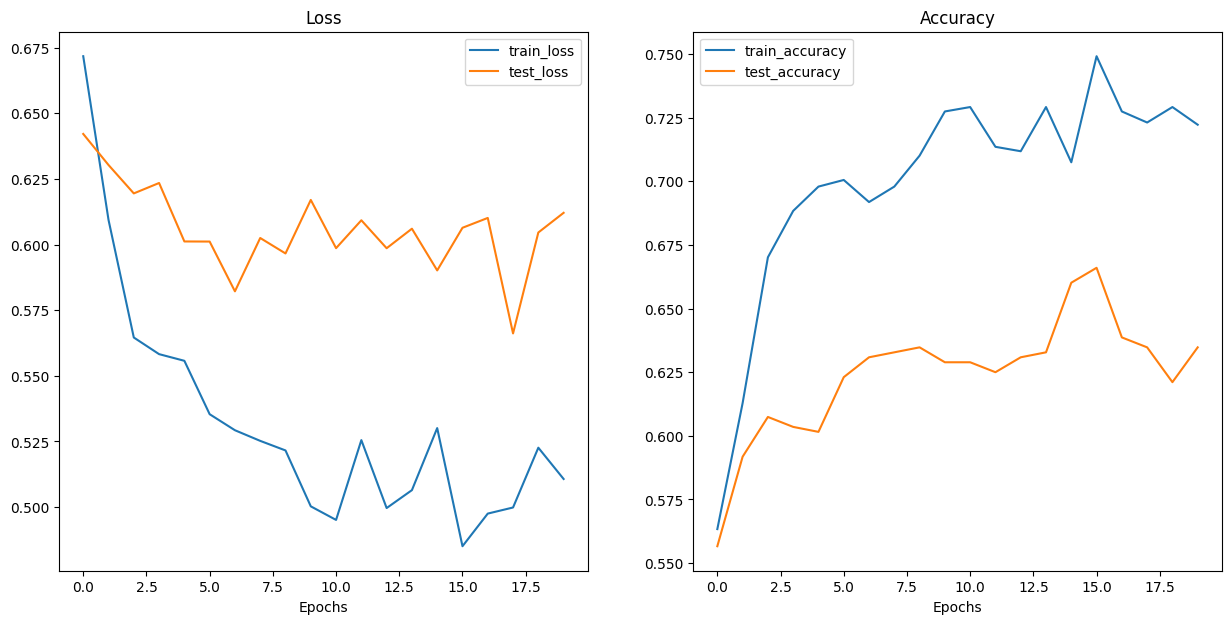

In [71]:
plot_loss_curves(efficient_results)

# Submission

In [72]:
x_test.shape 

(8424, 75, 75, 3)

In [73]:
test_dataset = IcebergCustom(x_test, transform=cnn_transforms)

In [74]:
test_dataloader = DataLoader(test_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=False)

In [75]:
cnn_model.load_state_dict(cnn_results['best_weight'])

<All keys matched successfully>

In [77]:
pred_data = []

with torch.no_grad():
    for image in test_dataloader:
        image = image.to(device)
        pred = cnn_model(image)
        y_pred = torch.sigmoid(pred)
        pred_data.extend(y_pred.squeeze().tolist())


pred_data[:10]

[0.5710420608520508,
 0.5905088186264038,
 0.25011053681373596,
 0.9914764761924744,
 0.04831884428858757,
 0.4967915713787079,
 0.19790709018707275,
 0.9916486740112305,
 0.08752622455358505,
 0.024652699008584023]

In [78]:
submission = pd.read_csv(args.default_submission_csv)
print(f'{submission.shape}')
submission.head()

(8424, 2)


,id,is_iceberg
0,5941774d,0.5
1,4023181e,0.5
2,b20200e4,0.5
3,e7f018bb,0.5
4,4371c8c3,0.5


In [79]:
submission['is_iceberg'] = pred_data
submission

,id,is_iceberg
0,5941774d,0.571042
1,4023181e,0.590509
2,b20200e4,0.250111
3,e7f018bb,0.991476
4,4371c8c3,0.048319
...,...,...
8419,16ee9b50,0.007311
8420,5a599eb7,0.073578
8421,df30d6dd,0.020614
8422,18af95b1,0.995893


In [80]:
submission.isnull().sum()

id            0
is_iceberg    0
dtype: int64

In [82]:
args.submission_csv = args.default_path+'submission_10.csv'
submission.to_csv(args.submission_csv, header=True, index=False)